In [33]:
import pandas as pd
import numpy as np

df = pd.read_csv('drives.csv')
threshold = 25
off_counts = df['offense_idx'].value_counts()
def_counts = df['defense_idx'].value_counts()
valid_off_teams = off_counts[off_counts >= threshold].index
valid_def_teams = def_counts[def_counts >= threshold].index

df_filtered = df[df['offense_idx'].isin(valid_off_teams) & df['defense_idx'].isin(valid_def_teams)].copy()
print("Total drives after filtering:", len(df_filtered))
df_filtered['yards_to_go'] = 100 - df_filtered['start_yardline']
print(df['drive_number'].unique())
df['drive_result'].unique()

Total drives after filtering: 61593
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


array(['PUNT', 'INT', 'TD', 'FUMBLE', 'MISSED FG', 'DOWNS', 'END OF HALF',
       'END OF GAME', 'FG', 'PUNT TD', 'END OF 4TH QUARTER', 'INT TD',
       'FUMBLE RETURN TD', 'SF', 'FUMBLE TD', 'PUNT RETURN TD',
       'BLOCKED PUNT', 'MISSED FG TD', 'BLOCKED FG', 'DOWNS TD', 'FG TD',
       'END OF HALF TD', 'END OF GAME TD', 'KICKOFF'], dtype=object)

In [34]:
df_4th = df_filtered[df_filtered['drive_result'].isin(['DOWNS', 'DOWNS TD', 'END OF 4TH QUARTER', 'END OF GAME'])].copy()
print("Total 4th down plays:", len(df_4th))

df_4th['fourth_down_success'] = df_4th['drive_result'].isin(['DOWNS TD', 'END OF 4TH QUARTER', 'END OF GAME'])

df_train = df_4th[df_4th['week'] < 9].copy()
df_test  = df_4th[df_4th['week'] > 8].copy()
print("Training 4th down plays:", len(df_train))
print("Testing 4th down plays:", len(df_test))

Total 4th down plays: 6495
Training 4th down plays: 3941
Testing 4th down plays: 2554


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

X_train = df_train[['yards_to_go', 'distance_to_goal']]
X_test  = df_test[['yards_to_go', 'distance_to_goal']]
y_train = df_train['fourth_down_success']
y_test  = df_test['fourth_down_success']
print("Unique classes in y_train:", y_train.unique())

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_1 = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

grid_search_1.fit(X_train, y_train)

print("Best parameters for Model 1:", grid_search_1.best_params_)

Unique classes in y_train: [False  True]
Best parameters for Model 1: {'C': 0.001}


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error


model = LogisticRegression(max_iter=1000, C=grid_search_1.best_params_['C'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_prob))
print("\nModel (4th down success without Team Coefficients):")
print("Test Accuracy:", round(acc, 3)*100, "%")
print("Test RMSE:", round(rmse, 3))


Model (4th down success withoit Team Coefficients):
Test Accuracy: 67.4 %
Test RMSE: 0.464


In [37]:
import pandas as pd

df_for_prediction = df_4th.dropna(subset=['yards_to_go', 'distance_to_goal']).copy()
print("Number of drives used for prediction:", len(df_for_prediction))

df_for_prediction['predicted_prob'] = model.predict_proba(
    df_for_prediction[['yards_to_go', 'distance_to_goal']]
)[:, 1]

team_predictions = df_for_prediction.groupby('offense').agg(
    total_attempts=('fourth_down_success', 'count'),
    actual_conversion_rate=('fourth_down_success', 'mean'),
    avg_predicted_prob=('predicted_prob', 'mean')
).reset_index()

team_predictions['actual_conversion_rate'] = team_predictions['actual_conversion_rate'] * 100
team_predictions['avg_predicted_prob'] = team_predictions['avg_predicted_prob'] * 100

team_predictions['actual_conversion_rate'] = team_predictions['actual_conversion_rate'].map("{:.2f}%".format)
team_predictions['avg_predicted_prob'] = team_predictions['avg_predicted_prob'].map("{:.2f}%".format)

team_predictions.to_csv("team_fourth_down_conversion_predictions_without_team_coefficients.csv", index=False)
print("Team-level fourth down conversion predictions saved to 'team_fourth_down_conversion_predictions_without_team_coefficients.csv'")
print(team_predictions.head())

Number of drives used for prediction: 6495
Team-level fourth down conversion predictions saved to 'team_fourth_down_conversion_predictions_without_team_coefficients.csv'
             offense  total_attempts actual_conversion_rate avg_predicted_prob
0  Abilene Christian               4                 25.00%             30.46%
1          Air Force              42                 45.24%             33.93%
2              Akron              42                 19.05%             32.82%
3            Alabama              27                 59.26%             33.58%
4        Alabama A&M               6                 33.33%             29.56%


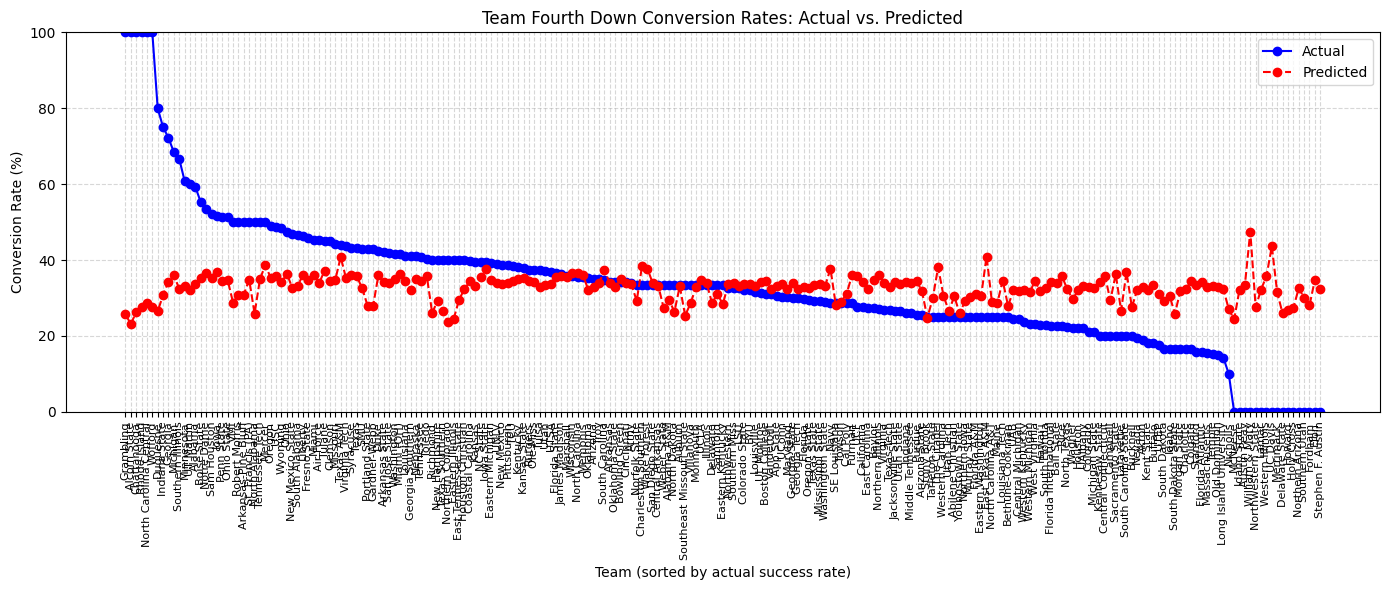

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_team = team_predictions.copy()

df_team['actual_conversion_rate_numeric'] = df_team['actual_conversion_rate'].str.rstrip('%').astype(float)
df_team['avg_predicted_prob_numeric'] = df_team['avg_predicted_prob'].str.rstrip('%').astype(float)

df_team = df_team.sort_values(by='actual_conversion_rate_numeric', ascending=False).reset_index(drop=True)

x = np.arange(len(df_team))

plt.figure(figsize=(14, 6))
plt.plot(x, df_team['actual_conversion_rate_numeric'], color='blue', linestyle='-', marker='o', label='Actual')
plt.plot(x, df_team['avg_predicted_prob_numeric'], color='red', linestyle='--', marker='o', label='Predicted')

plt.xlabel("Team (sorted by actual success rate)")
plt.ylabel("Conversion Rate (%)")
plt.title("Team Fourth Down Conversion Rates: Actual vs. Predicted")
plt.xticks(x, df_team['offense'], rotation=90, fontsize=8)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()